# Testing recommenders
In this notebook, I use the cleaned data set to test out different recommenders from the Surprise package. 

The biggest challenge is that there are complex trade-offs between…
* **accuracy** — making recommendations that the user will definitely like
* **serendipitiy** — making unexpected and interesting recommendations
* **runtime** — some recommenders require a lot more online computation (this is tough to assess, since he package I'm using isn't optimized for deploying the algos in realtime, e.g. in a web app)
* **updateability** — how and when the model needs to be updated, such as when a new user joins the platform or a new item enters the catalog

This means that choosing the best recommender requires consideration of lots of different factors.

The best compromise seems to be **simple item-based collaborative filtering**:
* among the most accurate (every model is about equal here, except recommending at random)
* covers the catalog the second best (only one model makes more surprising recs: recommending at random)
* really fast to run (the expensive thing - calculating item similarity - can be cached and reused)
* the model only needs to be updated when new items are added

The last part of the notebook uses gridsearch to find the best set of hyperparameters for item-based collaborative filtering. It didn't make sense to use gridsearch for every model, since they need to be evaluated on all four criteria.

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from surprise import Reader, Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.similarities import msd
from surprise import SVD, KNNWithMeans, KNNBasic, KNNWithZScore, KNNBaseline, NormalPredictor, BaselineOnly

## Setting up the data

In [110]:
bgg_steam_data = pd.read_csv('../bgg_steam_data_normed.csv', index_col=0)
bgg_steam_data.dropna(inplace=True)

no_expansions = pd.read_csv('../scraping_cleaning_normalizing/bgg_GameItem.csv')
no_expansions = set(no_expansions.name)
bgg_steam_data = bgg_steam_data[(bgg_steam_data.source=='steam')|\
                                (bgg_steam_data.game.isin(no_expansions))]

# Calculate user-item matrix sparsity

u_i_matrix = bgg_steam_data.pivot_table(index = 'game', columns = 'user', values = 'rating_normed')
u_i_matrix = u_i_matrix.fillna(0)
u_i_matrix.head()

user,0492372665,21n6y,2lip,8bitdad,aarontu,abnormalend,acorns2009,adamp,adiamant,adil3tr,...,zomboyd,zorac,zortag,zpak,zqfarnzy,zubon,zucho,zugman,zyzzyvas,zzokalj
game,,,,,,,,,,,,,,,,,,,,,
"...and then, we held hands.",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Days in Africa,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.538968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Days in Asia,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Days in Europe,0.0,0.0,0.0,0.0,6.372235,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Days in the Americas,0.0,0.0,0.0,0.0,6.372235,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
sparsity = (1.0 - np.count_nonzero(u_i_matrix) / u_i_matrix.size)*100
print('ui matrix has sparsity of {}'.format(sparsity))

ui matrix has sparsity of 96.11742396987904


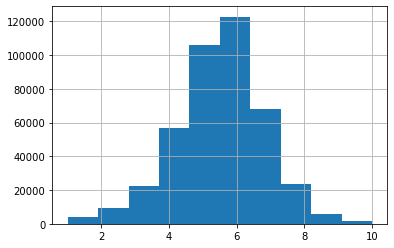

In [4]:
# Building recommenders
# Setup data

reader = Reader(rating_scale=(1,10))

bgg_steam_data.rating_normed.hist()
plt.show()

In [5]:
# Custom train-test split
# 90% of users are for training, 10% are for testing
# Test data: Boardgame ratings for test users
# Training data: All videogame ratings for all users, and boardgame ratings for training users

users_test = random.sample(list(bgg_steam_data.user.unique()), round((bgg_steam_data.user.nunique()/10)))

bool_is_testing = ((bgg_steam_data.user.isin(users_test))&(bgg_steam_data.source=='bgg'))
bool_is_training = ~bool_is_testing

# Load trainset and testset into Surprise-friendly format
trainset = bgg_steam_data[bool_is_training]
trainset = Dataset.load_from_df(trainset[['user', 'game', 'rating_normed']], reader)
trainset = trainset.build_full_trainset()

testset = bgg_steam_data[bool_is_testing]
testset = Dataset.load_from_df(testset[['user', 'game', 'rating_normed']], reader)
testset = testset.build_full_trainset()
testset = testset.build_testset()

# For testset, Surprise creates list of tuples
# containg username, gameid, rating out of 10
testset[0:5]

[('aggravity', 'Boss Monster 2: The Next Level', 4.330129040534644),
 ('aggravity',
  'Boss Monster: The Dungeon Building Card Game',
  2.312101635456909),
 ('aggravity', 'Coup: Rebellion G54', 5.002804842227223),
 ('aggravity', 'Eldritch Horror', 6.34815644561238),
 ('aggravity',
  'Epic Spell Wars of the Battle Wizards: Duel at Mt. Skullzfyre',
  4.330129040534644)]

In [152]:
# Surprise only makes predictions about titles which users have ratings for
# We need a testset that checks every testuser-boardgame combo

boardgames_in_testset = set(bgg_steam_data[((bool_is_training) & (bgg_steam_data.source == 'bgg'))].game)
testset_all = [(user, board_game, 5.5) for user in users_test for board_game in boardgames_in_testset]
testset_all[0:10]

[('disgustipater', 'Battlefleet Gothic', 5.5),
 ('disgustipater', 'Last Will', 5.5),
 ('disgustipater', 'Big Boggle', 5.5),
 ('disgustipater', 'Upwords', 5.5),
 ('disgustipater', 'Tash-Kalar: Arena of Legends', 5.5),
 ('disgustipater', 'Keltis: Das Kartenspiel', 5.5),
 ('disgustipater', 'Blood Bowl (Third Edition)', 5.5),
 ('disgustipater', 'Bootleggers', 5.5),
 ('disgustipater', 'Carcassonne: 10 Year Special Edition', 5.5),
 ('disgustipater', 'Wings of War: Burning Drachens', 5.5)]

## Trying out different algos

In [7]:
# For each algorithm, check RMSE, MAP@K, coverage
# Map@k is 10 by default -- ignores games that user hasn't rated
# Coverage here is total number of games served to user

# Precision recall at k is modified from Surprise docs
def precision_recall_at_k(predictions, k=10, threshold=5.5):
    '''
    Return precision and recall at k metrics for each user.
    '''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

def calculate_coverage(predictions, k=10):
    '''
    Input: Surprise predictions object
    Output: number of different catalog items recommended in 10
    '''
    user_est_true = defaultdict(list)
    top_k_games = []
    for uid, iid, _, est, _ in predictions:
        user_est_true[uid].append((est, iid))
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Number of recommended items in top k
        top_k_games += [game for (_, game) in user_ratings[0:k]]
    return len(set(top_k_games))


def assess_predictions(algo, testset=testset, testset_all=testset_all):
    '''
    Function that returns coverage, MAP@10 and RMSE from a Surprise algo
    Testset is used for RMSE and MAP@10
    Testset_all is used for coverage
    '''
    predictions = algo.test(testset)
    predictions_all = algo.test(testset_all)
    rmse = accuracy.rmse(predictions)
    coverage = calculate_coverage(predictions_all)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=5.5)
    mapk = sum(prec for prec in precisions.values()) / len(precisions)
    print('coverage: ' + str(coverage))
    print('MAP@10: ' + str(mapk))
    return None

def fit_algo_timed(algo, data):
    '''
    Fit a surprise algo on a trainset and time it
    '''
    start_time = time.time()
    algo.fit(data)
    duration = time.time() - start_time
    print('Fitting the model took {} seconds'.format(duration))

In [81]:
# SVD

algo = SVD()

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Fitting the model took 22.817111015319824 seconds
RMSE: 1.2383
coverage: 163
MAP@10: 0.7588206627680315


In [82]:
# Normal predictor - guess at random

algo = NormalPredictor()

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Fitting the model took 0.41327476501464844 seconds
RMSE: 1.8728
coverage: 943
MAP@10: 0.5264724310776943


In [83]:
# Guess average rating per game (taking into account user bias)

algo = BaselineOnly()

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Estimating biases using als...
Fitting the model took 0.739875078201294 seconds
RMSE: 1.1988
coverage: 10
MAP@10: 0.7687238930659983


In [84]:
# User-based collaborative filtering with baseline fallback
# Can't be sped up by caching similarity matrix
# Must calculate similarities between new user and all existing users

sim_options = {'name': 'cosine',
               'user_based': True
               }

algo = KNNBaseline(k=50, sim_options=sim_options)

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fitting the model took 3.223184108734131 seconds
RMSE: 1.2124
coverage: 27
MAP@10: 0.7469193817878029


In [85]:
# Item-based collaborative filtering with baseline fallback
# Can be sped up by caching item similarity matrix

sim_options = {'name': 'cosine',
               'user_based': False,  # compute  similarities between items
               }
algo = KNNBaseline(k=50, sim_options=sim_options)

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fitting the model took 40.213268995285034 seconds
RMSE: 1.2178
coverage: 86
MAP@10: 0.7805903648008908


In [86]:
# Item-based collaborative filtering without baseline fallback

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(k=50, sim_options=sim_options)

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Fitting the model took 37.41411519050598 seconds
RMSE: 1.3487
coverage: 465
MAP@10: 0.5558027011974381


In [141]:
# User-based collaborative filtering without baseline fallback

sim_options = {'name': 'cosine',
               'user_based': True,  # compute  similarities between items
               }
algo = KNNBasic(k=50, sim_options=sim_options)

fit_algo_timed(algo, trainset)
assess_predictions(algo)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Fitting the model took 2.194866180419922 seconds
RMSE: 1.2076
coverage: 25
MAP@10: 0.7526037315511003


## Grid search to tune item-based model

In [43]:
trainset_gs = bgg_steam_data[bool_is_training]
trainset_gs = Dataset.load_from_df(trainset_gs[['user', 'game', 'rating_normed']], reader)

param_grid = {'k': list(range(10, 50, 5)),
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5, 10],
                              'user_based': [False]}
              }

grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'])

grid_search.fit(trainset_gs)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarit

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine sim

In [88]:
# Best parameters from grid search
grid_search.best_params

{'rmse': {'k': 25,
  'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}},
 'mae': {'k': 20,
  'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}}

In [8]:
# Fit a model with the best parameters on the entire dataset
# Do this to get a similarity matrix

trainset_all = bgg_steam_data
trainset_all = Dataset.load_from_df(trainset_all[['user', 'game', 'rating_normed']], reader)
trainset_all = trainset_all.build_full_trainset()

sim_options = {'name': 'msd',
               'min_support': 5,
               'user_based': False  # compute  similarities between items
               }

algo = KNNBasic(k=25, sim_options=sim_options)

fit_algo_timed(algo, trainset_all)

Computing the msd similarity matrix...
Done computing similarity matrix.
Fitting the model took 13.247984886169434 seconds


In [9]:
# Get similarity matrix from model
similarity_matrix = algo.compute_similarities()
print(similarity_matrix.shape)

Computing the msd similarity matrix...
Done computing similarity matrix.
(8831, 8831)


In [10]:
# Add labels for game names
list_of_games = [algo.trainset.to_raw_iid(item) for item in list(algo.trainset.all_items())]
sim_matrix = pd.DataFrame(similarity_matrix, columns=list_of_games, index=list_of_games)
sim_matrix

,steam280,steam4000,steam40100,steam8190,steam34270,steam91600,steam620,steam105600,steam9420,steam9350,...,Unlock! Mystery Adventures,Fortuna,Brawl,John Company,Poison,Raise Your Goblets,The Cave,Best Treehouse Ever,Lucky Loop,Rumble in the House
steam280,1.000000,0.132139,0.276104,0.267483,0.276627,0.376667,0.178907,0.118956,0.216856,0.191923,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
steam4000,0.132139,1.000000,0.221838,0.171699,0.155656,0.205128,0.265197,0.209735,0.175723,0.157950,...,0.0,0.0,0.227728,0.0,0.0,0.0,0.0,0.182941,0.0,0.0
steam40100,0.276104,0.221838,1.000000,0.250909,0.190710,0.321436,0.215517,0.150873,0.353564,0.176893,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
steam8190,0.267483,0.171699,0.250909,1.000000,0.153429,0.204037,0.254132,0.146280,0.231953,0.153241,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
steam34270,0.276627,0.155656,0.190710,0.153429,1.000000,0.206133,0.156546,0.093346,0.134017,0.129631,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.374835,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Raise Your Goblets,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148523,0.094606,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
The Cave,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.171002,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0
Best Treehouse Ever,0.000000,0.182941,0.000000,0.000000,0.374835,0.000000,0.178538,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
Lucky Loop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0


In [155]:
# Make it so rows are video games and columns are boardgames
video_game_names = set(bgg_steam_data[bgg_steam_data.source=='steam'].game)
board_game_names = set(bgg_steam_data[bgg_steam_data.source=='bgg'].game)

sim_matrix = sim_matrix.loc[sim_matrix.index.isin(video_game_names), board_game_names]
sim_matrix.to_csv('sim_matrix.txt')

sim_matrix

,Battlefleet Gothic,Last Will,Big Boggle,Upwords,Tash-Kalar: Arena of Legends,Keltis: Das Kartenspiel,Blood Bowl (Third Edition),Bootleggers,Carcassonne: 10 Year Special Edition,Wings of War: Burning Drachens,...,Star Trek Panic,Ziegen Kriegen,Fresco,Exit: The Game – Dead Man on the Orient Express,Battle Cry: 150th Civil War Anniversary Edition,The End of the Triumvirate,SteamRollers,Chainsaw Warrior,Ghost Fightin' Treasure Hunters,Dead Man's Draw
steam280,0.000000,0.138417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam4000,0.212284,0.242532,0.597263,0.350117,0.296788,0.000000,0.205064,0.260327,0.0,0.242676,...,0.176107,0.0,0.222296,0.100603,0.0,0.513674,0.187052,0.21292,0.0,0.132148
steam40100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.267487,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam8190,0.000000,0.392988,0.000000,0.000000,0.248902,0.325625,0.508593,0.220034,0.0,0.387700,...,0.000000,0.0,0.362514,0.000000,0.0,0.210906,0.000000,0.00000,0.0,0.204146
steam34270,0.000000,0.245919,0.474680,0.133667,0.663284,0.000000,0.073347,0.218084,0.0,0.000000,...,0.000000,0.0,0.140472,0.000000,0.0,0.000000,0.384245,0.00000,0.0,0.162359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
steam824270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam706220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam382000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam533780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000


## How the model works, step by step

In [129]:
# In case the model can't predict a board game rating, it needs a list of
# average ratings for every board game across users to use a backup

bg_averages = bgg_steam_data[bgg_steam_data.source=="bgg"]
bg_averages = bg_averages.groupby('game').mean().rating_normed
bg_averages_df = pd.DataFrame(bg_averages).reset_index(level=0)

bg_averages_df
bg_averages_df.to_csv('bg_average_ratings.csv')

In [58]:
# First get all of the video game ratings for a user

test_user = bgg_steam_data.loc[(bgg_steam_data.user=='aggravity') & (bgg_steam_data.source=='steam'), ['user', 'rating_normed', 'game']]
test_user

,user,rating_normed,game
10119,aggravity,2.053530,steam2130
10120,aggravity,6.009172,steam2400
10121,aggravity,4.475471,steam2420
10122,aggravity,6.327840,steam10150
10123,aggravity,6.677679,steam6060
...,...,...,...
10177,aggravity,7.309035,steam489830
10178,aggravity,6.823244,steam493340
10179,aggravity,4.753715,steam1046930
10180,aggravity,4.890865,steam440


In [158]:
sim_matrix = pd.read_csv('sim_matrix.txt', index_col=0)
sim_matrix

,Battlefleet Gothic,Last Will,Big Boggle,Upwords,Tash-Kalar: Arena of Legends,Keltis: Das Kartenspiel,Blood Bowl (Third Edition),Bootleggers,Carcassonne: 10 Year Special Edition,Wings of War: Burning Drachens,...,Star Trek Panic,Ziegen Kriegen,Fresco,Exit: The Game – Dead Man on the Orient Express,Battle Cry: 150th Civil War Anniversary Edition,The End of the Triumvirate,SteamRollers,Chainsaw Warrior,Ghost Fightin' Treasure Hunters,Dead Man's Draw
steam280,0.000000,0.138417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam4000,0.212284,0.242532,0.597263,0.350117,0.296788,0.000000,0.205064,0.260327,0.0,0.242676,...,0.176107,0.0,0.222296,0.100603,0.0,0.513674,0.187052,0.21292,0.0,0.132148
steam40100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.267487,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam8190,0.000000,0.392988,0.000000,0.000000,0.248902,0.325625,0.508593,0.220034,0.0,0.387700,...,0.000000,0.0,0.362514,0.000000,0.0,0.210906,0.000000,0.00000,0.0,0.204146
steam34270,0.000000,0.245919,0.474680,0.133667,0.663284,0.000000,0.073347,0.218084,0.0,0.000000,...,0.000000,0.0,0.140472,0.000000,0.0,0.000000,0.384245,0.00000,0.0,0.162359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
steam824270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam706220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam382000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
steam533780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000


In [153]:
# The video games the user has played are looked up in the similarity matrix

test_sim = sim_matrix.loc[test_user.game]
test_sim

,Battlefleet Gothic,Last Will,Big Boggle,Upwords,Tash-Kalar: Arena of Legends,Keltis: Das Kartenspiel,Blood Bowl (Third Edition),Bootleggers,Carcassonne: 10 Year Special Edition,Wings of War: Burning Drachens,...,Star Trek Panic,Ziegen Kriegen,Fresco,Exit: The Game – Dead Man on the Orient Express,Battle Cry: 150th Civil War Anniversary Edition,The End of the Triumvirate,SteamRollers,Chainsaw Warrior,Ghost Fightin' Treasure Hunters,Dead Man's Draw
steam2130,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
steam2400,0.000000,0.243156,0.000000,0.125918,0.297024,0.0,0.148183,0.557111,0.000000,0.478937,...,0.000000,0.000000,0.262621,0.000000,0.000000,0.096055,0.000000,0.000000,0.000000,0.000000
steam2420,0.000000,0.282941,0.000000,0.000000,0.000000,0.0,0.211667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.438468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
steam10150,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.161914,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.486842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
steam6060,0.000000,0.266149,0.000000,0.000000,0.236470,0.0,0.402982,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.371868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
steam489830,0.000000,0.161533,0.000000,0.052561,0.183285,0.0,0.288491,0.165304,0.000000,0.000000,...,0.000000,0.000000,0.262422,0.000000,0.288933,0.000000,0.340945,0.000000,0.000000,0.000000
steam493340,0.000000,0.366732,0.000000,0.000000,0.326891,0.0,0.124345,0.281869,0.000000,0.000000,...,0.000000,0.000000,0.181300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
steam1046930,0.000000,0.342379,0.000000,0.000000,0.271124,0.0,0.000000,0.198358,0.247669,0.000000,...,0.000000,0.000000,0.275305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
steam440,0.332566,0.202721,0.175536,0.127803,0.249854,0.0,0.171038,0.149635,0.080030,0.205677,...,0.129414,0.167657,0.213907,0.220916,0.226678,0.344087,0.372504,0.164296,0.380060,0.104514


In [60]:
# For each boardgame, find the k most similar video games the user has played
# Exemplified here with Battlefield gothic

# These two parameters determine the maximum and minimum number of similar video games

k_neighbors = 25
min_support = 5

game = 'Battlefleet Gothic'
similar_games = test_sim.loc[test_sim[game] > 0, game]
similar_games = similar_games.sort_values(ascending=False)[0:k_neighbors]
similar_games

steam42910     0.369165
steam440       0.332566
steam65800     0.310344
steam400       0.257282
steam41800     0.251560
steam200510    0.248804
steam286160    0.241896
steam620       0.229075
steam98200     0.184097
steam268500    0.179499
steam230410    0.176337
steam570       0.161547
steam72850     0.146645
Name: Battlefleet Gothic, dtype: float64

In [75]:
# Get ratings for the similar games

similar_games_ratings = test_user.loc[test_user.game.isin(similar_games.index), 'rating_normed']
similar_games_ratings

10125    5.742291
10130    6.418270
10131    6.558056
10132    6.332585
10134    7.179046
10135    6.311862
10142    5.139054
10146    6.153923
10150    4.936969
10158    6.512704
10173    5.695180
10180    4.890865
10181    6.483743
Name: rating_normed, dtype: float64

In [85]:
# If there arent neighbors, use the average rating for the board game
# Otherwise, calculate the weighted average of similar games

if len(similar_games) < min_support:
    print('backup_rating')
else:
    weighted_sum = np.dot(similar_games_ratings, similar_games)
    total = similar_games.sum()
    weighted_average = weighted_sum/total
    print(weighted_average)

6.0771344986709


In [150]:
def predict_bg_ratings(boardgame_names, user_game_ratings, similarity_matrix, min_support=1, k_neighbors=20):
    '''
    Takes a list of boardgames and returns a list of predicted values
    
    Parameters:
        boardgame_names = list of boardgames
        user_game_ratings = dataframe with three columns (user, game, rating_normed)
        similarity_matrix = a matrix with rows as vgs and columns as bgs
        min_support = minimum number of neighbors for rating prediction
        k_neighbors = max number of neighbors for rating prediction
    '''
    
    # Only consider video games the user has rated
    similarity_matrix = similarity_matrix.loc[user_game_ratings.game]
    
    boardgame_ratings = []
    for boardgame in boardgame_names:
        try:
            all_similar_games = similarity_matrix.loc[similarity_matrix[boardgame] > 0, game]
        except:
            predicted_rating = np.nan
            boardgame_ratings.append(predicted_rating)
            continue
        k_similar_games = all_similar_games.sort_values(ascending=False)[0:k_neighbors]
        if len(k_similar_games) < min_support:
            predicted_rating = bg_averages_df.loc[bg_averages_df.game==boardgame, 'rating_normed'].values[0]
        else:
            k_similar_games_ratings = user_game_ratings.loc[user_game_ratings.game.isin(k_similar_games.index), 'rating_normed']
            weighted_sum = np.dot(k_similar_games_ratings, k_similar_games)
            total = k_similar_games.sum()
            weighted_average = weighted_sum/total
            predicted_rating = weighted_average
        boardgame_ratings.append(predicted_rating)
    return boardgame_ratings

In [151]:
# The last one doesn't meet the support threshhold
bgs = ['Battlefleet Gothic', 'Last Will', 'Bootleggers', 'Thisisntagame', 'Keltis: Das Kartenspiel']
test = predict_bg_ratings(bgs, test_user, sim_matrix, 5, 25)
test

[6.0771344986709,
 5.1844971497179415,
 5.482506345870781,
 nan,
 5.423831176512028]

In [164]:
pd.DataFrame(zip(bgs, test), columns = ['Game', 'Rating'])

,Game,Rating
0,Battlefleet Gothic,6.077134
1,Last Will,5.184497
2,Bootleggers,5.482506
3,Thisisntagame,NaN
4,Keltis: Das Kartenspiel,5.423831
